In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np

from numpy import hstack
from numpy import vstack
from numpy import asarray

from math import sqrt

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
try:
    from mlens.ensemble import SuperLearner
except:
    !pip install mlens
    from mlens.ensemble import SuperLearner

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#plot libaries
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
from plotly.offline import plot, iplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[MLENS] backend: threading


In [0]:
train_set_path = "/content/drive/My Drive/AML/train.csv"
test_set_path = "/content/drive/My Drive/AML/test.csv"

# train data frame
train_df = pd.read_csv(train_set_path)
train_df['area_code'] = train_df['area_code'].map(lambda x: x.split("area_code_")[1]).astype("int64")
train_df.churn.replace(('no', 'yes'), (0, 1), inplace=True)

# test data frame
test_df = pd.read_csv(test_set_path)
test_df = test_df.drop(['id'], axis=1)
test_df['area_code'] = test_df['area_code'].map(lambda x: x.split("area_code_")[1]).astype("int64")

# for reproducing results
defaultSeed = 5

# Store label
target = train_df['churn']
train_df.drop(['churn'], axis = 1, inplace = True)

In [4]:
one_hot_enc = OneHotEncoder()
categories = ['state', 'area_code', 'international_plan', 'voice_mail_plan']

catagorical_data_train = train_df.loc[:,categories]
one_hot_enc.fit(catagorical_data_train)
one_hot = pd.DataFrame(one_hot_enc.transform(catagorical_data_train).toarray())
train_df = pd.concat([train_df, one_hot], axis = 1)
train_df.drop(categories, axis = 1, inplace = True)

catagorical_data_test = test_df.loc[:,categories]
one_hot_enc.fit(catagorical_data_test)
one_hot = pd.DataFrame(one_hot_enc.transform(catagorical_data_test).toarray())
test_df = pd.concat([test_df, one_hot], axis = 1)
test_df.drop(categories, axis = 1, inplace = True)

train_df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,121,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [5]:
# high imbalance
y = target.value_counts()
print(y.map(lambda x: x / target.size))

# plot target value to show imbalance
colors = plotly.colors.DEFAULT_PLOTLY_COLORS
churn_dict = {0: "no churn", 1: "churn"}
data = [go.Bar(x=[churn_dict[x] for x in y.index], y=y.values, marker = dict(color = colors[:len(y.index)]))]
layout = go.Layout(
    title='Churn distribution',
    autosize=False,
    width=400,
    height=400,
    yaxis=dict(
        title='#samples',
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic-bar15')

0    0.859294
1    0.140706
Name: churn, dtype: float64


In [0]:
# Store features for train and test
feature_matrix = train_df.values.astype(np.float)
feature_matrix_test = test_df.values.astype(np.float)

# Scaling
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)
feature_matrix_test = scaler.fit_transform(feature_matrix_test)

In [0]:
def model_fit(alg, features, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features, target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, target)
        
    #Predict training set:
    predictions = alg.predict(features)
    predictions = (predictions > 0.5)
    predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.5g" % metrics.accuracy_score(target.values, predictions))

    conf_mtr = (metrics.confusion_matrix(target.values, predictions))
    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    sns.heatmap(conf_mtr,cmap = cmap,xticklabels=['P','N'],yticklabels=['P','N'],annot=True, fmt="d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
                    
    try:
        feature_importance = alg.feature_importances_
        feat_importances = pd.Series(alg.feature_importances_, index=train_df.columns)
        feat_importances = feat_importances.nlargest(19)
        feat_importances.plot(kind='barh' , figsize=(10,10))
    except:
        print("Model has no feature_importances_ property")
    
def model_predict(alg, features, target, test_set, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features, target)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])

    predictions = alg.predict(test_set)
    predictions = (predictions > 0.5)

    churn_col = ['churn']
    predictions = pd.DataFrame(predictions, columns = churn_col)
    predictions.replace((0,1),('no', 'yes'), inplace=True)

    id_col = ['id']
    id = pd.DataFrame([i for i in range (1,751)], columns = id_col)

    predictions = pd.concat([id,predictions],axis=1)
    predictions.to_csv("/content/drive/My Drive/AML/submission.csv",index=False)

def x_validate(X, y, classifier, shuffle=True, n_folds=10):
    # we shall use stratified sampling because the data is not balanced
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=defaultSeed)
    y_pred = y.copy()
    
    for train_index, test_index in stratified_k_fold.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        classifier.fit(X_train,y_train)
        y_pred[test_index] = classifier.predict(X_test)

    y_pred = (y_pred > 0.5)
        
    #Print model report:
    print("\n------------", str(classifier).split("(")[0], "---------------")

    conf_mtr = (metrics.confusion_matrix(target.values, y_pred))
    cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    sns.heatmap(conf_mtr,cmap = cmap,xticklabels=['P','N'],yticklabels=['P','N'],annot=True, fmt="d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
 
    print("Accuracy : %.5g" % metrics.accuracy_score(target.values, y_pred))
    
    return y_pred

# create a list of base-models
def get_models():
    models = list()
    models.append(DecisionTreeClassifier(random_state=defaultSeed))
    models.append(BaggingClassifier(random_state=defaultSeed))
    models.append(RandomForestClassifier(random_state=defaultSeed))
    models.append(ExtraTreesClassifier(random_state=defaultSeed))
    models.append(GradientBoostingClassifier(random_state=defaultSeed))
    models.append(XGBClassifier(random_state=defaultSeed))
    return models
 
# create the super learner
def get_super_learner(X):
    ensemble = SuperLearner(scorer=metrics.accuracy_score, folds=10, shuffle=True, sample_size=len(X), verbose=2, random_state=defaultSeed)
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(LogisticRegression(solver='lbfgs'))
    ensemble.add_meta(RandomForestClassifier())
    ensemble.add_meta(GradientBoostingClassifier())
    return ensemble


Model Report
Accuracy : 0.98212


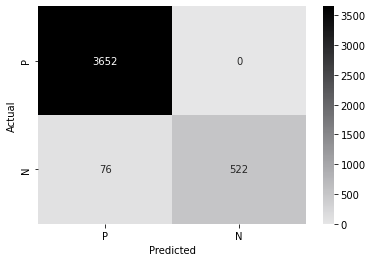

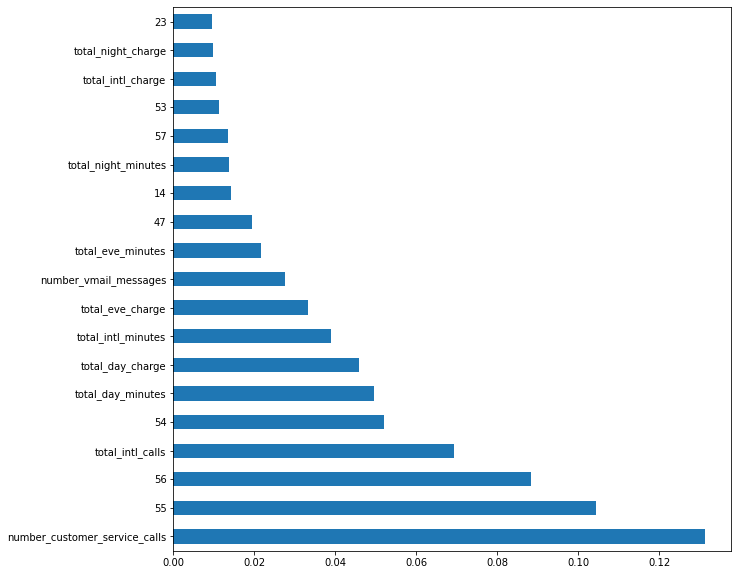

In [13]:
xg_boost = XGBClassifier(
    learning_rate = 0.3,
    n_estimators = 1000,
    max_depth = 8,
    min_child_weight = 0,
    gamma = 0.8,
    subsample = 0.9,
    colsample_bytree = 0.7,
    reg_alpha = 0.1,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = defaultSeed
)
model_fit(xg_boost, feature_matrix, target)
model_predict(xg_boost, feature_matrix, target, feature_matrix_test)

Below are other well performing approaches. Uncomment to run.
This version of the super learner is not the optimal (I lost it...) but it is very intiguing to me so I kept it.

In [0]:
# print("-----------Super Learner-----------")
# target_values = np.array([i[0] for i in pd.DataFrame(target).reindex().values])
# features = pd.DataFrame(feature_matrix).reindex().values
# X, X_val, y, y_val = train_test_split(features, target_values, test_size=0.30)

# print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)

# # create the super learner
# ensemble = get_super_learner(X)
# # fit the super learner
# ensemble.fit(X, y)
# # summarize base learners
# print(ensemble.data)
# # make predictions on hold out set
# yhat = ensemble.predict(X_val)
# print('Super Learner: %.3f' % (metrics.accuracy_score(y_val, yhat) * 100))

In [0]:
# X_train, X_val, y_train, y_val = train_test_split(pd.DataFrame(feature_matrix), target, test_size=0.2, random_state=defaultSeed)

# voting_clf = VotingClassifier(estimators=[('RandomForest', RF_clf), ('ExtraTrees', ExTr_clf),
#                                           ('GradientBoost', GB_clf), ('XGBoost', XGB_clf)], voting='hard', n_jobs=-1)

# ## TESTS
# print("----------Neural Network----------")
# network = Sequential()
# network.add(layers.Dense(units=64, activation='relu'))
# network.add(layers.Dropout(0.5, seed=0))
# network.add(layers.Dense(units=64, activation='relu'))
# network.add(layers.Dropout(0.5, seed=0))
# network.add(layers.Dense(units=32, activation='relu'))
# network.add(layers.Dropout(0.5, seed=0))
# network.add(layers.Dense(units=1, activation='sigmoid'))

# network.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# network.fit(X_train, y_train, batch_size = 20, epochs = 200)

# models = get_models()
# for model in models:
#     x_validate(feature_matrix, target, model)

# print("\n-------------XGBoost Tunned--------------")
# xg_boost = XGBClassifier(
#     learning_rate = 0.3,
#     n_estimators = 1000,
#     max_depth = 8,
#     min_child_weight = 0,
#     gamma = 0.8,
#     subsample = 0.9,
#     colsample_bytree = 0.7,
#     reg_alpha = 0.1,
#     objective = 'binary:logistic',
#     nthread = 4,
#     scale_pos_weight = 1,
#     seed = defaultSeed
# )
# model_fit(xg_boost, feature_matrix, target)

# print("-----------Voting/Committee------------")
# estimator_options = [('RandomForest', RF_clf), ('ExtraTrees', ExTr_clf), ('GradientBoost', GB_clf), ('XGBoost', XGB_clf)]
# estimator_combinations = []
# for i in range(1, len(estimator_options) + 1):
#     for combo in combinations(estimator_options, i):
#         estimator_combinations.append(combo)

# grid_param = {
#     'voting': ['hard', 'soft'],
#     'estimators': estimator_combinations
# }

# gd_sr = GridSearchCV(estimator=voting_clf,
#                      param_grid=grid_param,
#                      scoring='accuracy',
#                      cv=5,
#                      n_jobs=-1)

# gd_sr.fit(X_train, y_train)

# best_parameters = gd_sr.best_params_
# print(best_parameters)

# best_result = gd_sr.best_score_
# print(best_result)

In [0]:
# # Prediction on test set
# test_features = pd.DataFrame(feature_matrix_test).reindex().values

# predictions = ensemble.fit(features, target_values).predict(test_features)
# predictions = (predictions > 0.5)

# churn_col = ['churn']
# predictions = pd.DataFrame(predictions, columns = churn_col)
# predictions.replace((0,1),('no', 'yes'), inplace=True)

# id_col = ['id']
# id = pd.DataFrame([i for i in range (1,751)], columns = id_col)

# predictions = pd.concat([id,predictions],axis=1)
# predictions.to_csv("/content/drive/My Drive/AML/submission.csv",index=False)